## Step 1 Data Preparation
### 1.1 Read files

In [1]:
import json

with open('dataset/org/train_annotation.json') as f:
    train_annotations = json.load(f)
with open('dataset/org/val_annotation.json') as f:
    val_annotations = json.load(f)
with open('dataset/org/train_question.json') as f:
    train_questions = json.load(f)
with open('dataset/org/val_question.json') as f:
    val_questions = json.load(f)
    
train_annotations = train_annotations['annotations']
val_annotations = val_annotations['annotations']
train_questions = train_questions['questions']
val_questions = val_questions['questions']

train_questions_text = [x['question'] for x in train_questions]
val_questions_text = [x['question'] for x in val_questions]
train_annotations_text = [x['multiple_choice_answer'] for x in train_annotations]
val_annotations_text = [x['multiple_choice_answer'] for x in val_annotations]

train_image_dir = 'dataset/org/train_image/'
val_image_dir = 'dataset/org/val_image/'
train_image_paths = [
    f'{train_image_dir}abstract_v002_train2015_{q["image_id"]:012d}.png'
    for q in train_questions
]
val_image_paths = [
    f'{val_image_dir}abstract_v002_val2015_{q["image_id"]:012d}.png'
    for q in val_questions
]

### 1.2 Tokenizer and Dataset

In [2]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader

class Vocabulary:
    def __init__(self):
        self.word2idx = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.idx2word = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.index = 4

    def add_sentence(self, sentence):
        for word in sentence.lower().split():
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.index
            self.idx2word[self.index] = word
            self.index += 1

    def sentence_to_indices(self, sentence, max_length):
        indices = [self.word2idx.get(word, self.word2idx["<UNK>"]) for word in sentence.lower().split()]
        indices = [self.word2idx["<SOS>"]] + indices[:max_length-2] + [self.word2idx["<EOS>"]]
        padding = [self.word2idx["<PAD>"]] * (max_length - len(indices))
        return indices + padding

class VQADataset(Dataset):
    def __init__(self, image_paths, questions, answers, vocab, transform=None, max_question_length=15):
        self.image_paths = image_paths
        self.questions = questions
        self.answers = answers
        self.vocab = vocab
        self.transform = transform
        self.max_question_length = max_question_length
        self.buffer = dict()

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        if idx in self.buffer:
            return self.buffer[idx][0], self.buffer[idx][1], self.buffer[idx][2]
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        question = self.questions[idx]
        question_indices = self.vocab.sentence_to_indices(question, self.max_question_length)
        question_tensor = torch.tensor(question_indices, dtype=torch.long)
        
        answer = self.answers[idx]
        # answer_index = self.vocab.word2idx.get(answer.lower(), self.vocab.word2idx["<UNK>"])
        answer_index = 0 if answer == 'no' else 1
        
        self.buffer[idx] = (image, question_tensor, torch.tensor(answer_index, dtype=torch.long))
        return self.buffer[idx][0], self.buffer[idx][1], self.buffer[idx][2]

### 1.3 Dataloader

In [3]:
from torchvision import transforms

vocab = Vocabulary()
for q in train_questions_text + val_questions_text:
    vocab.add_sentence(q)
for a in train_annotations_text + val_annotations_text:
    vocab.add_word(a)

print("Vocabulary size:", len(vocab.word2idx))

# https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = VQADataset(train_image_paths, train_questions_text, train_annotations_text, vocab, transform=image_transform)
val_dataset = VQADataset(val_image_paths, val_questions_text, val_annotations_text, vocab, transform=image_transform)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


Vocabulary size: 4473


In [4]:
first_samples = 0
for images, questions, answers in val_loader:
    first_samples += torch.sum(answers == 0)
print(first_samples / len(val_dataset))

tensor(0.5079)


In [5]:
from tqdm import tqdm

for images, questions, answers in tqdm(train_loader):
    pass
for images, questions, answers in tqdm(val_loader):
    pass
print('Dataset Images Buffered!')

100%|██████████| 45/45 [00:01<00:00, 30.50it/s]

Dataset Images Buffered!


## Step 2: Model

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

class NeuralImageQA(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1):
        super(NeuralImageQA, self).__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.output_dims = 2
        
        ## CNN
        self.cnn = models.resnet18(pretrained=True)
        self.cnn = nn.Sequential(*list(self.cnn.children())[:-1])  # Remove the original last layer
        self.img_feat_dim = 512
        
        # LSTM
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(input_size=self.img_feat_dim + embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        
        ## Output prediction
        self.fc = nn.Linear(hidden_dim, self.output_dims) # Linear layer for decoding
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, images, questions):
        batch_size = images.size(0)
        
        # CNN input features
        img_feats = self.cnn(images)  # (batch_size, 512, 1, 1)
        img_feats = img_feats.view(batch_size, -1)  # (batch_size, 512)
        
        # LSTM input features
        question_embeds = self.embedding(questions)  # (batch_size, question_length, embedding_dim)
        img_feats_expanded = img_feats.unsqueeze(1).repeat(1, questions.size(1), 1) # (batch_size, question_length, img_feat_dim)
        lstm_input = torch.cat((img_feats_expanded, question_embeds), dim=2)  # (batch, question_length, img_feat_dim + embedding_dim)
        
        # LSTM forward pass
        h0 = torch.zeros(1, batch_size, self.hidden_dim).to(images.device)
        c0 = torch.zeros(1, batch_size, self.hidden_dim).to(images.device)
        
        lstm_out, _ = self.lstm(lstm_input, (h0, c0))  # Shape: (batch_size, question_length, hidden_dim)
        lstm_out_latent = lstm_out[:, -1, :].squeeze(1)  # Shape: (batch_size, hidden_dim)
        output_word_logits = self.fc(lstm_out_latent)
        # predicted_word = output_word_logits.argmax(dim=1) # Shape: (batch_size), each of an idx
        
        return self.softmax(output_word_logits)

## Step 3: Training

In [8]:
import torch.optim as optim

vocab_size = len(vocab.word2idx)
embedding_dim = 300
hidden_dim = 512
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralImageQA(vocab_size, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

/root/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        # with torch.no_grad():
        #     for images, questions, answers in train_loader:
        #         print(answers)
        #         images, questions, answers = images.to(device), questions.to(device), answers.to(device)
        #         outputs = model(images, questions)
        #         loss = criterion(outputs, answers)
        #         predicted_words = outputs.argmax(dim=1)
        #         print(predicted_words)
        #         break
        #         delta_correct = torch.sum(predicted_words == answers).cpu().item()
        #         # print('delta', delta_correct)
        #         correct_sum += delta_correct
        
        for images, questions, answers in tqdm(train_loader):
            images, questions, answers = images.to(device), questions.to(device), answers.to(device)
            
            optimizer.zero_grad()
            outputs = model(images, questions)
            # print(outputs.shape, outputs.dtype, answers.dtype)
            loss = criterion(outputs, answers)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")
        
        # Validation
        model.eval()
        val_loss = 0.0
        correct_sum = 0
        with torch.no_grad():
            for images, questions, answers in val_loader:
                # print(answers)
                images, questions, answers = images.to(device), questions.to(device), answers.to(device)
                outputs = model(images, questions)
                # print(outputs)
                loss = criterion(outputs, answers)
                val_loss += loss.item()
                predicted_words = outputs.argmax(dim=1)
                # print(predicted_words)
                # break
                
                delta_correct = torch.sum(predicted_words == answers).cpu().item()
                # print('delta', delta_correct)
                correct_sum += delta_correct
        print(f"Validation Loss: {val_loss / len(val_loader):.4f}, Acc: {correct_sum / len(val_dataset):.4f}")
        # break

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

100%|██████████| 87/87 [00:15<00:00,  5.58it/s]


Epoch [1/20], Loss: 0.6964
Validation Loss: 0.6929, Acc: 0.5092


100%|██████████| 87/87 [00:15<00:00,  5.73it/s]


Epoch [2/20], Loss: 0.6941
Validation Loss: 0.6929, Acc: 0.5104


100%|██████████| 87/87 [00:15<00:00,  5.77it/s]


Epoch [3/20], Loss: 0.6920
Validation Loss: 0.6926, Acc: 0.5095


100%|██████████| 87/87 [00:15<00:00,  5.70it/s]


Epoch [4/20], Loss: 0.6909
Validation Loss: 0.6921, Acc: 0.5176


100%|██████████| 87/87 [00:15<00:00,  5.67it/s]


Epoch [5/20], Loss: 0.6883
Validation Loss: 0.6908, Acc: 0.5260


100%|██████████| 87/87 [00:15<00:00,  5.68it/s]


Epoch [6/20], Loss: 0.6832
Validation Loss: 0.6945, Acc: 0.5174


100%|██████████| 87/87 [00:15<00:00,  5.69it/s]


Epoch [7/20], Loss: 0.6753
Validation Loss: 0.6948, Acc: 0.5265


100%|██████████| 87/87 [00:15<00:00,  5.67it/s]


Epoch [8/20], Loss: 0.6617
Validation Loss: 0.6986, Acc: 0.5262


100%|██████████| 87/87 [00:15<00:00,  5.68it/s]


Epoch [9/20], Loss: 0.6409
Validation Loss: 0.7059, Acc: 0.5312


100%|██████████| 87/87 [00:15<00:00,  5.68it/s]


Epoch [10/20], Loss: 0.6166
Validation Loss: 0.7242, Acc: 0.5265


100%|██████████| 87/87 [00:15<00:00,  5.67it/s]


Epoch [11/20], Loss: 0.5919
Validation Loss: 0.7443, Acc: 0.5199


100%|██████████| 87/87 [00:15<00:00,  5.67it/s]


Epoch [12/20], Loss: 0.5702
Validation Loss: 0.7304, Acc: 0.5285


100%|██████████| 87/87 [00:15<00:00,  5.68it/s]


Epoch [13/20], Loss: 0.5528
Validation Loss: 0.7410, Acc: 0.5243


100%|██████████| 87/87 [00:15<00:00,  5.70it/s]


Epoch [14/20], Loss: 0.5342
Validation Loss: 0.7464, Acc: 0.5260


100%|██████████| 87/87 [00:15<00:00,  5.66it/s]


Epoch [15/20], Loss: 0.5209
Validation Loss: 0.7558, Acc: 0.5293


100%|██████████| 87/87 [00:15<00:00,  5.69it/s]


Epoch [16/20], Loss: 0.5096
Validation Loss: 0.7473, Acc: 0.5328


100%|██████████| 87/87 [00:15<00:00,  5.76it/s]


Epoch [17/20], Loss: 0.5004
Validation Loss: 0.7581, Acc: 0.5291


100%|██████████| 87/87 [00:15<00:00,  5.75it/s]


Epoch [18/20], Loss: 0.4938
Validation Loss: 0.7547, Acc: 0.5305


100%|██████████| 87/87 [00:15<00:00,  5.76it/s]


Epoch [19/20], Loss: 0.4900
Validation Loss: 0.7602, Acc: 0.5263


100%|██████████| 87/87 [00:15<00:00,  5.75it/s]


Epoch [20/20], Loss: 0.4816
Validation Loss: 0.7578, Acc: 0.5337


In [10]:
total_sum = 0
correct_sum = 0

with torch.no_grad():
    for images, questions, answers in val_loader:
        images, questions, answers = images.to(device), questions.to(device), answers.to(device)
        outputs = model(images, questions)
        predicted_words = outputs.argmax(dim=1)
        total_sum += outputs.shape[0]
        # print(predicted_words.shape, answers.shape)
        correct_sum += torch.sum(predicted_words == answers).cpu().item()
        # print(correct_sum)

print(correct_sum, total_sum, correct_sum/total_sum)

6046 11328 0.5337217514124294


In [11]:
with torch.no_grad():
    for images, questions, answers in val_loader:
        images, questions, answers = images.to(device), questions.to(device), answers.to(device)
        outputs = model(images, questions)
        predicted_words = outputs.argmax(dim=1)
        print(predicted_words == answers)
        break

tensor([False, False,  True, False, False,  True, False, False, False, False,
        False,  True,  True, False,  True,  True, False,  True,  True, False,
        False,  True,  True, False,  True, False, False, False,  True, False,
        False,  True, False,  True, False,  True,  True,  True, False, False,
         True, False, False, False,  True, False, False, False, False,  True,
         True,  True,  True, False, False, False, False, False,  True,  True,
        False,  True,  True, False,  True,  True,  True,  True, False, False,
        False, False,  True, False, False,  True,  True, False,  True,  True,
        False,  True,  True, False, False, False,  True, False,  True,  True,
        False, False, False,  True,  True, False,  True, False, False,  True,
         True, False,  True, False,  True, False, False,  True, False,  True,
        False,  True,  True,  True,  True,  True, False, False, False,  True,
        False,  True, False,  True,  True, False,  True,  True, 

In [12]:
from matplotlib import pyplot as plt
image_wrong0 = Image.open(val_image_paths[0]).convert('RGB')
question_wrong0 = val_questions_text[0]
image_wrong1 = Image.open(val_image_paths[1]).convert('RGB')
question_wrong1 = val_questions_text[1]
image_right0 = Image.open(val_image_paths[2]).convert('RGB')
question_right0 = val_questions_text[2]
image_right1 = Image.open(val_image_paths[3]).convert('RGB')
question_right1 = val_questions_text[3]

images = [image_wrong0, image_wrong1, image_right0, image_right1]
questions = [
    'Wrong: ' + question_wrong0, 
    'Wrong: ' + question_wrong1, 
    'Right: ' + question_right0, 
    'Right: ' + question_right1
]

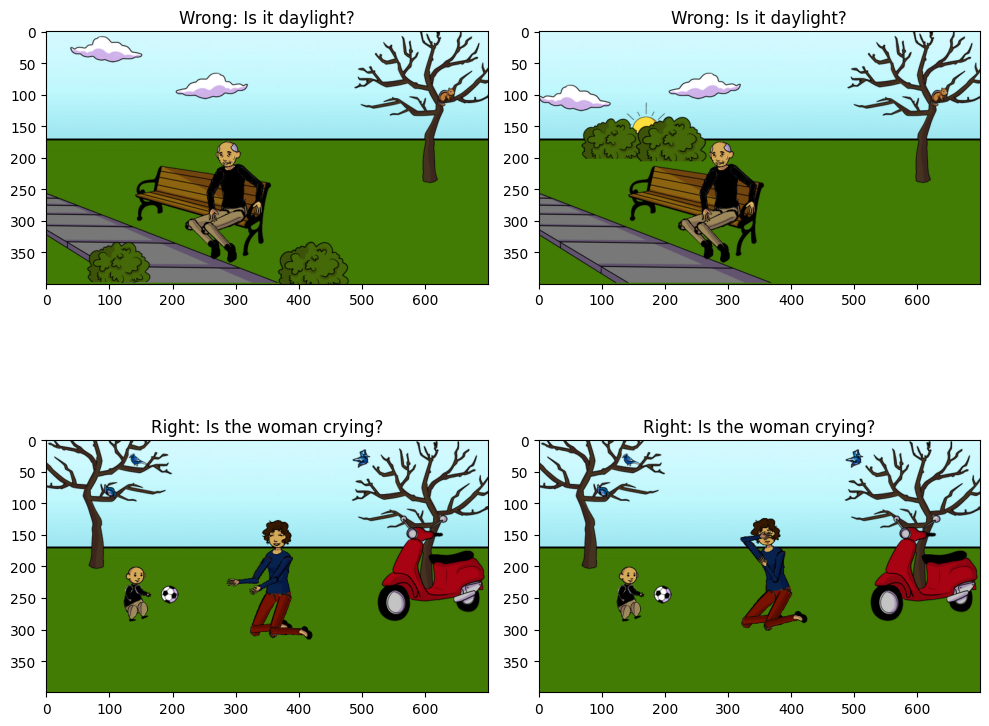

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(10, 9))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.title(questions[i])
    plt.imshow(images[i])

plt.tight_layout()
plt.show()

## Step 4: LIME Explanation

In [91]:
import numpy as np
from skimage.segmentation import slic, felzenszwalb
from matplotlib import pyplot as plt

def perturb_image(image: np.array, num_samples: int):
    perturbations, masks = list(), list()
    
    # num_segments = int(num_samples / 20)
    # segments = slic(image, n_segments=num_segments, start_label=0)
    
    grid_size = 16
    print('image.shape', image.shape)
    H, W = image.shape[2:]
    print(f'H: {H}, W: {W}')
    num_rows = (H + grid_size - 1) // grid_size
    num_cols = (W + grid_size - 1) // grid_size
    num_segments = num_rows * num_cols

    segments = np.zeros((1, 3, H, W), dtype=int)
    segment_id = 0
    for row in range(num_rows):
        for col in range(num_cols):
            row_start, row_end = row * grid_size, min((row + 1) * grid_size, H)
            col_start, col_end = col * grid_size, min((col + 1) * grid_size, W)
            segments[0, :, row_start:row_end, col_start:col_end] = segment_id
            segment_id += 1
    
    for _ in range(num_samples):
        mask = np.random.randint(0, 2, num_segments)
        perturbation = image.copy()
        for seg_idx in range(num_segments):
            if mask[seg_idx] == 0:
                perturbation[segments==seg_idx] = 0
        assert np.sum(mask) != 0
        # print(mask)
        perturbations.append(perturbation)
        masks.append(mask)
    
    return perturbations, masks, segments

def preprocess_images(images, preprocess) -> torch.tensor:
    print('images[0].shape', images[0].shape)
    # plt.imshow(images[0].squeeze(0).transpose(1, 2, 0))
    outputs = list()
    for image in images:
        image = torch.tensor(image)
        outputs.append(image)
    return torch.cat(outputs, dim=0)

In [92]:
from sklearn.linear_model import LinearRegression

def LIME(image, question, model, preprocess, original_label, num_samples=1000, device='cuda'):
    model.to(device)
    pert_images, pert_masks, segments = perturb_image(image, num_samples)
    # print('pert_images[0].shape:', pert_images[0].shape)
    pert_images = preprocess_images(pert_images, preprocess)
    # print('question.shape', question.shape)
    questions = question.unsqueeze(0).repeat(num_samples, 1).to('cuda')
    # print('pert_images.shape', pert_images.shape)
    
    pert_images = pert_images.to(device)
    with torch.no_grad():
        # print('pert_images', pert_images.shape, 'questions', questions.shape)
        yhat = model(pert_images, questions)
        probabilities = torch.softmax(
            yhat, dim=1
        )[:, original_label].cpu().numpy()
    
    linear_model = LinearRegression()
    linear_model.fit(pert_masks, probabilities)
    segment_importance = linear_model.coef_ # dim=num_segments
    
    importance_map = np.zeros_like(image, dtype=np.float32)
    for seg_idx in range(segment_importance.size):
        importance_map[segments==seg_idx] = segment_importance[seg_idx]
    return importance_map

In [93]:
def image_regularization(image: np.array, alpha=0.5):
    normalized_map = (image - image.min()) / (image.max() - image.min() + 1e-8)
    enhanced_map = normalized_map ** alpha
    return enhanced_map

Question:  Is it daylight?
Expected shape: torch.Size([1, 3, 224, 224]) torch.Size([1, 15])
Predicted label: 0
image.shape (1, 3, 224, 224)
H: 224, W: 224


images[0].shape (1, 3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 224, 224)


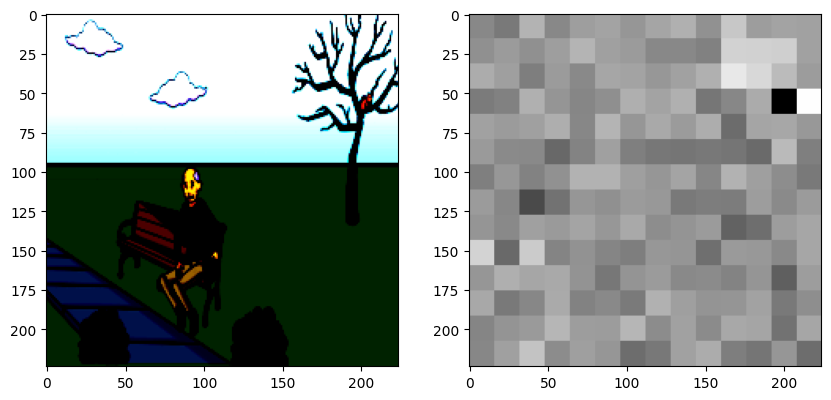

Question:  Is it daylight?
Expected shape: torch.Size([1, 3, 224, 224]) torch.Size([1, 15])
Predicted label: 0
image.shape (1, 3, 224, 224)
H: 224, W: 224
images[0].shape (1, 3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 224, 224)


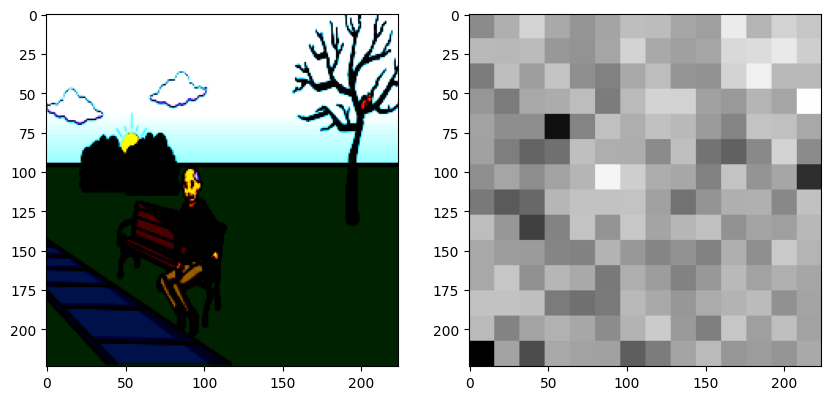

Question:  Is the woman crying?
Expected shape: torch.Size([1, 3, 224, 224]) torch.Size([1, 15])
Predicted label: 0
image.shape (1, 3, 224, 224)
H: 224, W: 224
images[0].shape (1, 3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 224, 224)


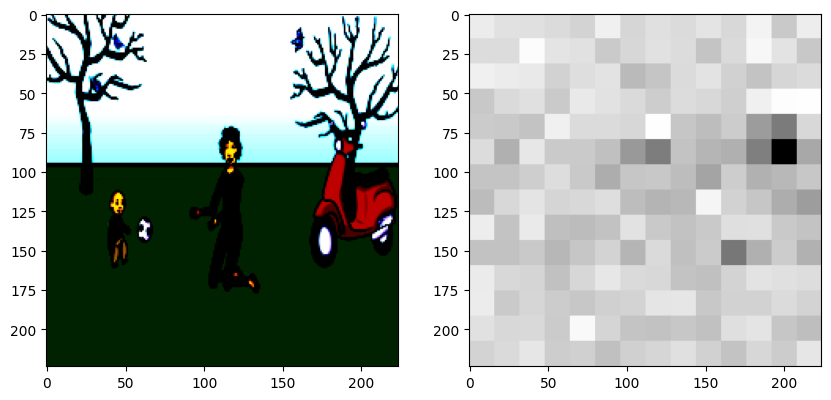

Question:  Is the woman crying?
Expected shape: torch.Size([1, 3, 224, 224]) torch.Size([1, 15])
Predicted label: 1
image.shape (1, 3, 224, 224)
H: 224, W: 224
images[0].shape (1, 3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 224, 224)


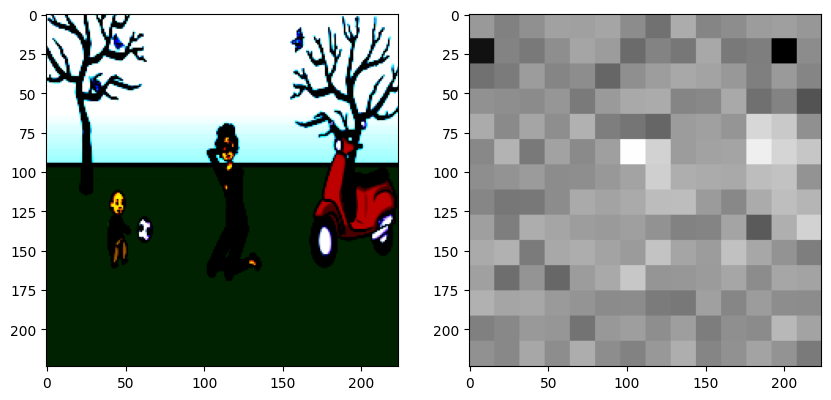

Question:  Did they just move into this house?
Expected shape: torch.Size([1, 3, 224, 224]) torch.Size([1, 15])
Predicted label: 0
image.shape (1, 3, 224, 224)
H: 224, W: 224
images[0].shape (1, 3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 224, 224)


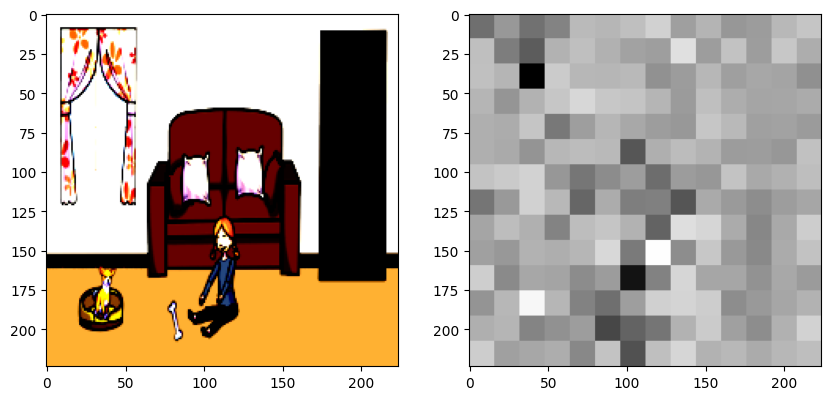

Question:  Did they just move into this house?
Expected shape: torch.Size([1, 3, 224, 224]) torch.Size([1, 15])
Predicted label: 0
image.shape (1, 3, 224, 224)
H: 224, W: 224
images[0].shape (1, 3, 224, 224)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 3, 224, 224)


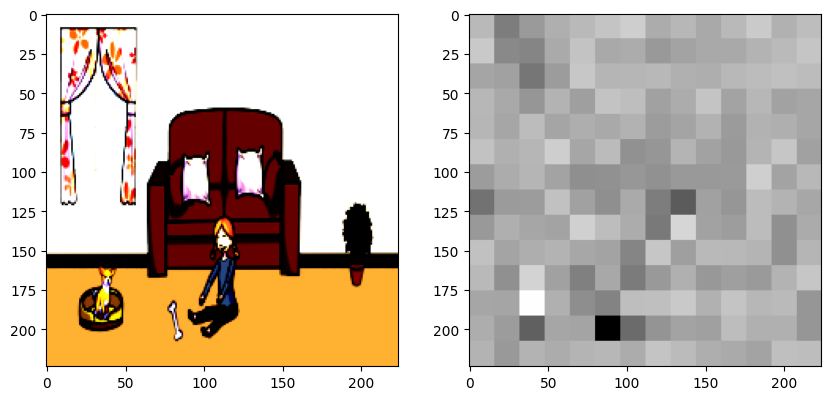

Question:  Is the girl trying to awaken the cat?


In [94]:
from matplotlib import pyplot as plt
import os
import json

res = {}
i = 0
for image, question, answer in val_dataset:
    print('Question: ', val_questions_text[i])
    if i == 6: break
    i += 1
    
    input_batch_img = image.unsqueeze(0)
    input_batch_txt = question.unsqueeze(0)
    if torch.cuda.is_available():
        input_batch_img = input_batch_img.to('cuda')
        input_batch_txt = input_batch_txt.to('cuda')
        model.to('cuda')

    # Perform inference
    with torch.no_grad():
        print('Expected shape:', input_batch_img.shape, input_batch_txt.shape)
        output = model(input_batch_img, input_batch_txt)

    # Get the predicted class index
    _, predicted_idx = torch.max(output, 1)
    predicted_idx = predicted_idx.item()

    print(f"Predicted label: {predicted_idx}")
    
    image = np.array(input_batch_img.cpu())
    importance_map = LIME(image, question, model, None, predicted_idx)
    assert np.max(importance_map) != np.min(importance_map)
    importance_map = image_regularization(importance_map)
    print(importance_map.shape)
    importance_map = importance_map.squeeze(0).transpose(1, 2, 0)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze(0).transpose(1, 2, 0))
    plt.subplot(1, 2, 2)
    plt.imshow(importance_map, cmap='hot')
    plt.show()

with open('LIME.json', 'w') as f:
    json.dump(res, f, indent='  ')